# UFC Outcome XGBoost Baseline
This notebook builds a simple gradient-boosted tree baseline (XGBoost) to predict fight outcomes — red win, blue win, or draw/no contest — using the scraped UFC fight statistics.

## Prerequisites
Install dependencies in your active environment if they are not already available:
```bash
pip install xgboost scikit-learn pandas matplotlib seaborn
```

In [11]:

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

DATA_DIR = Path("ufc_out")
assert DATA_DIR.exists(), "Expected scraped data in ./ufc_out/"


In [12]:

fights = pd.read_csv(DATA_DIR / "fights.csv")
totals_overall = pd.read_csv(DATA_DIR / "fight_totals_overall.csv")
sig_overall = pd.read_csv(DATA_DIR / "fight_sig_overall.csv")

fights.head()


,fight_id,fight_url,event_id,event_date,red_id,red_name,red_result,blue_id,blue_name,blue_result,method,referee,end_round,end_time
0,1a191251620a84ca,http://ufcstats.com/fight-details/1a191251620a...,00a905a4a4a2b071,2022-09-03,77d7295d1b22c694,Alessio Di Chirico,L,9d83f6da776ff7d6,Roman Kopylov,W,KO/TKO,Rich Mitchell,3,1:09
1,20f316f96c9e4458,http://ufcstats.com/fight-details/20f316f96c9e...,00a905a4a4a2b071,2022-09-03,881bf86d4cba8578,Nassourdine Imavov,W,b9437600497350f3,Joaquin Buckley,L,Decision - Unanimous,Marc Goddard,3,5:00
2,398db40015b3c81c,http://ufcstats.com/fight-details/398db40015b3...,00a905a4a4a2b071,2022-09-03,e1d40e8782d80bc2,William Gomis,W,082eba4cd80f736f,Jarno Errens,L,Decision - Majority,Jason Herzog,3,5:00
3,3e2f00991f511607,http://ufcstats.com/fight-details/3e2f00991f51...,00a905a4a4a2b071,2022-09-03,c2299ec916bc7c56,Benoit Saint Denis,W,b909a9a9688b5284,Gabriel Miranda,L,KO/TKO,Jason Herzog,2,0:16
4,7bced112f3229b1b,http://ufcstats.com/fight-details/7bced112f322...,00a905a4a4a2b071,2022-09-03,c21a036b4e012f1c,John Makdessi,L,b7b84ccd221be298,Nasrat Haqparast,W,Decision - Unanimous,Marc Goddard,3,5:00


## Feature Engineering
Each totals/sig table contains one row per fighter per fight. We reshape them so that features for the red and blue corners sit on the same row, and then add difference features (red minus blue).

In [13]:

def reshape_stats(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    """Return wide features for red/blue fighters from overall stat tables."""
    df = df[df["level"] == "overall"].copy()
    if df.empty:
        return pd.DataFrame()

    df["fighter_id"] = df["fighter_id"].astype(str)
    id_lookup = fights[["fight_id", "red_id", "blue_id"]].copy()
    id_lookup["fight_id"] = id_lookup["fight_id"].astype(str)
    id_lookup["red_id"] = id_lookup["red_id"].astype(str)
    id_lookup["blue_id"] = id_lookup["blue_id"].astype(str)
    df["fight_id"] = df["fight_id"].astype(str)

    df = df.merge(id_lookup, on="fight_id", how="inner")

    drop_cols = {
        "fight_id",
        "event_id",
        "event_date",
        "level",
        "round",
        "table",
        "fighter_id",
        "red_id",
        "blue_id",
    }
    value_cols = [c for c in df.columns if c not in drop_cols]

    red_rows = (
        df[df["fighter_id"] == df["red_id"]]
        .set_index("fight_id")[value_cols]
        .add_prefix(f"{prefix}_red_")
    )

    blue_rows = (
        df[df["fighter_id"] == df["blue_id"]]
        .set_index("fight_id")[value_cols]
        .add_prefix(f"{prefix}_blue_")
    )

    wide = red_rows.join(blue_rows, how="inner")
    return wide

totals_wide = reshape_stats(totals_overall, "tot")
sig_wide = reshape_stats(sig_overall, "sig")

features = totals_wide.join(sig_wide, how="inner")
features.head()


,tot_red_kd,tot_red_sig_str_landed,tot_red_sig_str_attempted,tot_red_sig_str_pct,tot_red_total_str_landed,tot_red_total_str_attempted,tot_red_td_landed,tot_red_td_attempted,tot_red_td_pct,tot_red_sub_att,...,sig_blue_body_landed,sig_blue_body_attempted,sig_blue_leg_landed,sig_blue_leg_attempted,sig_blue_distance_landed,sig_blue_distance_attempted,sig_blue_clinch_landed,sig_blue_clinch_attempted,sig_blue_ground_landed,sig_blue_ground_attempted
fight_id,,,,,,,,,,,,,,,,,,,,,
1a191251620a84ca,0,39,126,30.0,43,131,0,4,0.0,0,...,12,12,10,10,55,118,4,4,0,0
20f316f96c9e4458,0,51,109,46.0,68,142,2,7,28.0,2,...,8,13,11,16,44,171,2,3,0,0
398db40015b3c81c,0,32,70,45.0,69,121,3,5,60.0,0,...,8,14,2,7,15,47,5,6,0,0
3e2f00991f511607,3,42,67,62.0,81,110,1,1,100.0,0,...,7,7,0,0,17,34,3,3,0,0
7bced112f3229b1b,0,73,196,37.0,73,196,0,0,NaN,0,...,19,29,4,5,60,168,4,5,0,0


In [14]:

diff_features = {}
for col in features.columns:
    if "_red_" in col:
        blue_col = col.replace("_red_", "_blue_")
        if blue_col in features.columns:
            diff_name = col.replace("_red_", "_diff_")
            diff_features[diff_name] = features[col] - features[blue_col]

diff_df = pd.DataFrame(diff_features)
feature_matrix = pd.concat([features, diff_df], axis=1)

feature_matrix.head()


,tot_red_kd,tot_red_sig_str_landed,tot_red_sig_str_attempted,tot_red_sig_str_pct,tot_red_total_str_landed,tot_red_total_str_attempted,tot_red_td_landed,tot_red_td_attempted,tot_red_td_pct,tot_red_sub_att,...,sig_diff_body_landed,sig_diff_body_attempted,sig_diff_leg_landed,sig_diff_leg_attempted,sig_diff_distance_landed,sig_diff_distance_attempted,sig_diff_clinch_landed,sig_diff_clinch_attempted,sig_diff_ground_landed,sig_diff_ground_attempted
fight_id,,,,,,,,,,,,,,,,,,,,,
1a191251620a84ca,0,39,126,30.0,43,131,0,4,0.0,0,...,-6,0,-6,-5,-17,5,-3,-1,0,0
20f316f96c9e4458,0,51,109,46.0,68,142,2,7,28.0,2,...,1,0,-9,-10,-8,-83,6,7,7,11
398db40015b3c81c,0,32,70,45.0,69,121,3,5,60.0,0,...,2,4,6,2,12,15,-3,-3,3,5
3e2f00991f511607,3,42,67,62.0,81,110,1,1,100.0,0,...,-2,-1,2,2,7,9,-1,-1,16,22
7bced112f3229b1b,0,73,196,37.0,73,196,0,0,NaN,0,...,-1,12,25,28,12,27,-3,-4,0,0


In [15]:

def map_outcome(row: pd.Series) -> int | None:
    red = (row.get("red_result") or "").strip().upper()
    blue = (row.get("blue_result") or "").strip().upper()
    if red.startswith("W"):
        return 0  # red win
    if blue.startswith("W"):
        return 1  # blue win
    if red.startswith("D") or blue.startswith("D"):
        return 2  # draw
    if "NC" in red or "NC" in blue:
        return 2
    return None

fights["target"] = fights.apply(map_outcome, axis=1)
targets = fights.set_index("fight_id")["target"]
dataset = feature_matrix.join(targets, how="inner")
dataset = dataset.dropna(subset=["target"]).copy()
dataset.head()


,tot_red_kd,tot_red_sig_str_landed,tot_red_sig_str_attempted,tot_red_sig_str_pct,tot_red_total_str_landed,tot_red_total_str_attempted,tot_red_td_landed,tot_red_td_attempted,tot_red_td_pct,tot_red_sub_att,...,sig_diff_body_attempted,sig_diff_leg_landed,sig_diff_leg_attempted,sig_diff_distance_landed,sig_diff_distance_attempted,sig_diff_clinch_landed,sig_diff_clinch_attempted,sig_diff_ground_landed,sig_diff_ground_attempted,target
fight_id,,,,,,,,,,,,,,,,,,,,,
1a191251620a84ca,0,39,126,30.0,43,131,0,4,0.0,0,...,0,-6,-5,-17,5,-3,-1,0,0,1
20f316f96c9e4458,0,51,109,46.0,68,142,2,7,28.0,2,...,0,-9,-10,-8,-83,6,7,7,11,0
398db40015b3c81c,0,32,70,45.0,69,121,3,5,60.0,0,...,4,6,2,12,15,-3,-3,3,5,0
3e2f00991f511607,3,42,67,62.0,81,110,1,1,100.0,0,...,-1,2,2,7,9,-1,-1,16,22,0
7bced112f3229b1b,0,73,196,37.0,73,196,0,0,NaN,0,...,12,25,28,12,27,-3,-4,0,0,1


In [16]:

X = dataset.drop(columns=["target"])
y = dataset["target"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((6673, 81), (1669, 81))

In [17]:

model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    tree_method="hist",
    random_state=42,
)

model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


/Users/acheung/Documents/GitHub/UFCPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/acheung/Documents/GitHub/UFCPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/acheung/Documents/GitHub/UFCPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

              precision    recall  f1-score   support

     Red win       0.90      0.92      0.91      1058
    Blue win       0.84      0.85      0.85       581
     Draw/NC       0.00      0.00      0.00        30

    accuracy                           0.88      1669
   macro avg       0.58      0.59      0.59      1669
weighted avg       0.86      0.88      0.87      1669



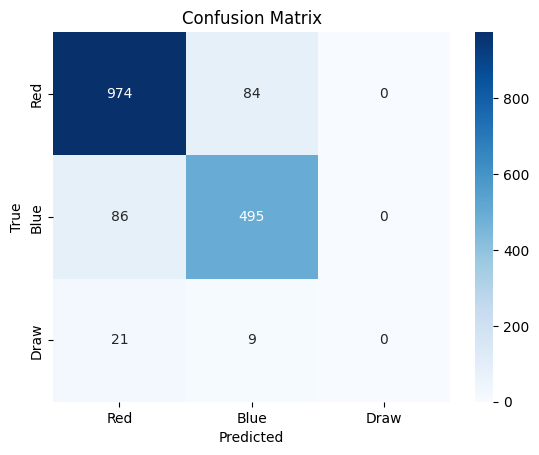

In [18]:

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Red win", "Blue win", "Draw/NC"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Red", "Blue", "Draw"],
            yticklabels=["Red", "Blue", "Draw"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


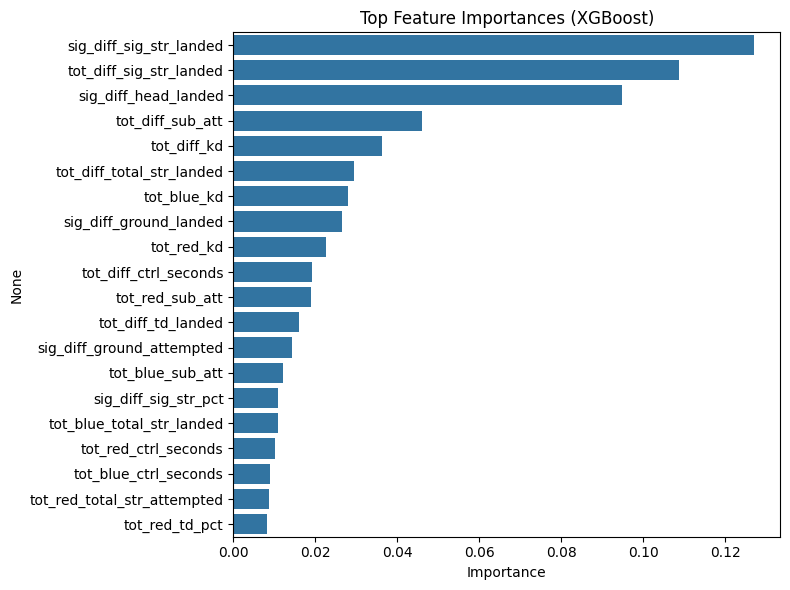

In [19]:

importance = pd.Series(model.feature_importances_, index=X_train.columns)
top_features = importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## Next Steps
* Incorporate fighter history (recent fight averages, win streaks).
* Include event metadata (weight class, main event).
* Hyperparameter tuning (e.g., with Optuna or cross-validation).
* Address class imbalance (draws/NC are rare) via class weights or focal objectives.